In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_data_1.log',
#              './training_data/head_data_2.log',
#              './training_data/head_data_3.log',
#              './training_data/head_data_4.log',
#              './training_data/head_data_5.log',
#              './training_data/head_data_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data_old/shoulder_right_data_1.log',
#              './training_data_old/shoulder_right_data_2.log',
#              './training_data_old/shoulder_right_data_3.log',
#              './training_data_old/shoulder_right_data_4.log',
#              './training_data_old/shoulder_right_data_5.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data/shoulder_right_train_10_17.log',
#              './training_data_old/shoulder_right_data_6.log',
#              './training_data_old/shoulder_right_data_7.log',
#              './training_data_old/shoulder_right_data_8.log',
#              './training_data_old/shoulder_right_data_9.log',
#             ]

body_part = "shoulder_left"
file_names = ['./training_data/shoulder_left_train_2.log',
              './training_data/shoulder_left_train_5_6_7_9_10.log'
             ]

# file_names = ['./training_data/shoulder_left_5.log',
#               './training_data/shoulder_left_6.log',
#               './training_data/shoulder_left_7.log']

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_1.log',
#               './training_data/shoulder_left_2.log',
#               './training_data/shoulder_left_3.log']

In [3]:
orig_dataset = pd.concat([pd.read_csv(f, delim_whitespace=True, header=0) for f in file_names])
orig_dataset = orig_dataset.values[1:len(orig_dataset)-1,0:]

abnormal_threshold = 0.5
dataset = []

for name in file_names:
    df = pd.read_csv(name, delim_whitespace=True, header=0)
    
    # interpolate nan outputs (loss tracking)
#     for c in df.columns[-3:]:
#         df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
    for c in df.columns[:-3]:
        bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
        df.loc[bad_idx, c] = np.nan
        df[c] = df[c].interpolate()
    
    dataset.append(df)
    
dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 

print(f'{np.sum(dataset_len)} values')

dataset = dataset.values[1:len(dataset)-1,0:]
dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]

print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

264538 values
264536 values after filtering outliers
max euler nan
min euler nan


In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [5]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

In [6]:
model_path = f"./outputs/{body_part}_dvbf_ad_rot6D"

sensors_scaler = joblib.load(f'{model_path}/scaler.pkl')

# Split magnetic sensors into 4 independent distributions again
orig_sensors_set = sensors_scaler.transform(orig_sensors_set).reshape(-1, 4, 3)
sensors_set = sensors_scaler.transform(sensors_set).reshape(-1, 4, 3)

In [7]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import mse_seq
from libs.dvbf_models import DVBF

In [8]:
model = DVBF.load_from_checkpoint(checkpoint_path=f"{model_path}/best.ckpt")

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [9]:
device = "cuda"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

DVBF(
  (initial_lstm): LSTM(12, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (initial_to_params): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
  (w1_to_z1): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
  )
  (matrix_params): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
    (3): Softmax(dim=None)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
  )
  (regressor_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
  (encoder_models

In [10]:
def plot_test(sensors_set, euler_set, look_back=5, ab_idx=None, save_name=None):

    # Specific testing for abnormalities
    
    if body_part == "shoulder_right":
        start_idx = 110090
        end_idx = 110790
        ab_idx = 110690
    elif body_part == "shoulder_left":
        start_idx = 21500 # 4500
        end_idx = 22880 # 4850
        ab_idx = 22626
    elif body_part == "head":
        start_idx = 900
        end_idx = 950

    test_idxs = slice(start_idx, end_idx)

    # Prepare inputs and do the prediction
    in_set = []
    for i in range(start_idx, end_idx):
        in_set.append(sensors_set[i:i+look_back])

    in_set = torch.tensor(sensors_set[start_idx:end_idx][None], dtype=torch.float32).to(device)
    out_set = model.predict(in_set)[0]#[:, -1]
    rot_pred = compute_rotation_matrix_from_ortho6d(out_set)

    euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred)
    euler_gt = torch.tensor(euler_set[test_idxs], dtype=torch.float32).to(device)
    
    print(f"MSE: {mse_seq(euler_pred, euler_gt)}")
    
    euler_pred = euler_pred.cpu().detach().numpy()
    euler_gt = euler_gt.cpu().detach().numpy()

    # Plotting
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(euler_gt[:, 0], euler_gt[:, 1], euler_gt[:, 2], c=np.arange(len(euler_gt)), alpha=0.1)
    sc = ax.plot(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2])
    sc = ax.scatter(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2], c=np.arange(len(euler_pred)), alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.colorbar(sc)
    plt.show()
    
    ax.set_xlim([-2, 0.5])
    ax.set_ylim([-1.5, 0.])
    ax.set_zlim([-2, 0.])
    
    if save_name:
        fig.savefig('./outputs/'+body_part+'_'+save_name+'.png', dpi=100, bbox_inches='tight')
    
    # Abnormal analysis
    latent_dist = None
    if ab_idx is not None:
        ab_idx = ab_idx - start_idx
        latent_dist = model.inv_meas(in_set[:, ab_idx])
        print(f"Abnormal input: {in_set[:, ab_idx]}")
    return latent_dist

In [11]:
test_euler_set = dataset[:, 12:15]

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


MSE: nan


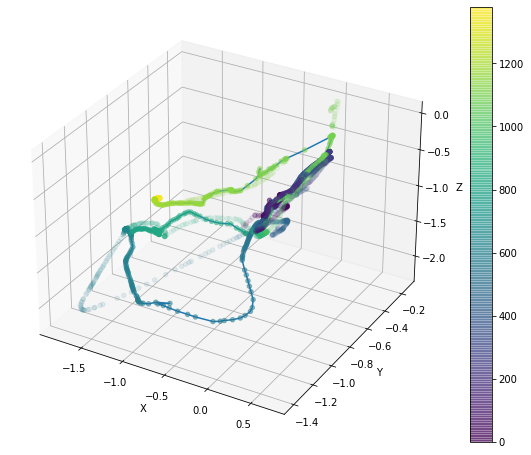

Abnormal input: tensor([[[ 0.5697,  0.3738,  0.5440],
         [-0.8198,  0.3476, -0.6963],
         [-0.3613, -0.1297,  0.0805],
         [-0.2853,  0.1305,  0.0181]]], device='cuda:0')


In [12]:
# Plot with raw inputs
test_latent_dist = plot_test(sensors_set, test_euler_set, look_back=10)

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


MSE: nan


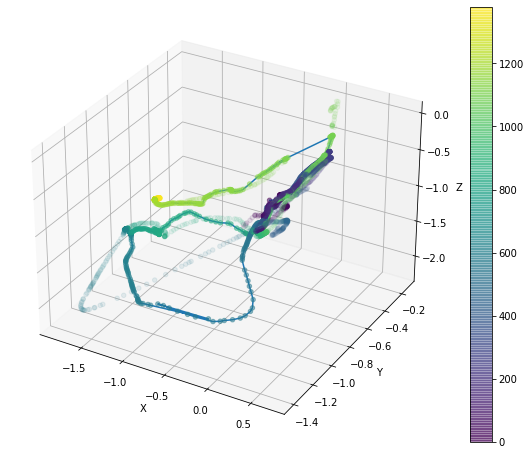

Abnormal input: tensor([[[ 0.5697,  0.0712,  0.6661],
         [-0.8198,  0.4511, -0.1063],
         [-0.3613, -0.1297,  0.0965],
         [-0.2853,  0.1305,  0.0181]]], device='cuda:0')


In [13]:
# Plot with interpolated inputs
orig_latent_dist = plot_test(orig_sensors_set, test_euler_set, save_name="dvbf")

In [14]:
test_latent_mean = torch.stack(test_latent_dist[0])
test_latent_var = torch.stack(test_latent_dist[1])

In [15]:
orig_latent_mean = torch.stack(orig_latent_dist[0])
orig_latent_var = torch.stack(orig_latent_dist[1])

In [16]:
(test_latent_mean - orig_latent_mean).abs().cpu().numpy()

array([[[1.5113684e+00, 1.8051500e+00, 1.3649502e+00, 1.7806072e+00,
         1.8040562e-01, 1.2475338e+00, 3.2274151e-01, 2.2075644e+00,
         5.2021027e-01, 1.9352531e-01, 2.8298378e-01, 1.7964935e-01,
         2.7715101e+00, 2.1042065e-01, 1.8155384e+00, 5.7644367e-01]],

       [[4.0873966e+00, 4.1061878e+00, 7.1670532e-01, 6.5737276e+00,
         3.5906658e+00, 1.1977453e+00, 1.5162258e+00, 7.4444962e-01,
         1.0179539e+00, 4.2890520e+00, 8.9739914e+00, 2.0248451e+00,
         3.6683493e+00, 5.0645962e+00, 2.1957474e+00, 7.4194145e-01]],

       [[1.7712021e-01, 1.6814327e-01, 1.2922955e-01, 8.5918427e-02,
         8.5083961e-02, 3.1396866e-02, 1.4976263e-02, 2.2305012e-01,
         9.4812155e-02, 3.9676666e-02, 1.5594292e-01, 1.5642405e-02,
         4.7307968e-02, 9.3848228e-02, 7.5991154e-03, 3.3624649e-02]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0

In [17]:
(test_latent_var - orig_latent_var).abs().cpu().numpy()

array([[[6.32084277e+03, 8.62478447e+00, 3.81771011e+01, 6.80271101e+00,
         3.84732666e+01, 3.42690945e-01, 1.28357434e+00, 1.76479340e-01,
         2.24912167e-02, 1.36860771e+01, 1.84302926e+00, 2.28900909e+01,
         6.00074083e-02, 1.24843895e-01, 3.21933031e-01, 6.33355618e-01]],

       [[2.05210495e+00, 5.97782612e+00, 1.80099964e-01, 1.36618614e-02,
         8.98531094e+04, 3.53444576e-01, 1.13674927e+01, 9.50449586e-01,
         4.57899952e+00, 2.08299637e-01, 5.36010861e-02, 4.44913149e-01,
         1.04794502e-02, 3.98187447e+00, 1.85320282e+01, 1.72008972e+01]],

       [[4.69517708e-03, 7.29184151e-02, 2.02218294e-01, 3.13935089e+00,
         9.72647667e-02, 8.14111710e-01, 1.73456669e-02, 1.41703963e-01,
         1.48720455e+00, 6.35279083e+00, 1.86235905e-02, 7.06180573e-01,
         4.38362360e-02, 9.94470119e-02, 1.68471336e-02, 7.62188911e-01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0

In [18]:
test_latent_var

tensor([[[7.8750e+03, 3.1416e+01, 1.1593e+02, 1.1999e+01, 1.3402e+02,
          3.1462e+00, 3.7545e+00, 1.1230e+00, 1.4027e-01, 3.2449e+01,
          3.2981e+00, 8.4464e+01, 1.9172e-01, 7.5634e-01, 2.6770e+00,
          2.9400e+00]],

        [[1.8281e+01, 3.6859e+00, 5.2611e+00, 2.1685e+00, 3.1225e+03,
          3.2647e+00, 5.9932e+01, 2.2463e+00, 2.7783e+00, 7.7444e+00,
          6.0257e-01, 1.1710e+00, 1.5725e-01, 1.4299e+01, 6.0266e+00,
          4.0937e+01]],

        [[1.8593e+00, 2.3399e+00, 3.8000e+00, 1.2788e+02, 3.0043e+00,
          1.7491e+01, 4.5524e-01, 1.3819e+00, 1.2025e+01, 7.9310e+01,
          1.3298e+00, 1.7131e+01, 1.2819e+00, 3.5991e+00, 2.5383e+00,
          1.3454e+01]],

        [[1.7209e+00, 1.1362e+00, 7.4280e+03, 2.7081e+03, 3.4478e+00,
          1.3303e+01, 1.8098e+00, 3.1287e+00, 6.4873e-01, 6.2967e+00,
          6.9590e+00, 9.4727e-01, 9.3682e-01, 1.7454e+01, 1.4973e+00,
          9.4140e+00]]], device='cuda:0')

In [19]:
orig_latent_var

tensor([[[1.5542e+03, 2.2791e+01, 7.7752e+01, 5.1964e+00, 1.7250e+02,
          2.8035e+00, 2.4710e+00, 9.4652e-01, 1.6276e-01, 1.8763e+01,
          5.1411e+00, 1.0735e+02, 1.3171e-01, 8.8119e-01, 2.9989e+00,
          3.5733e+00]],

        [[2.0333e+01, 9.6637e+00, 5.4412e+00, 2.1548e+00, 9.2976e+04,
          2.9113e+00, 7.1300e+01, 1.2958e+00, 7.3573e+00, 7.5361e+00,
          5.4897e-01, 7.2613e-01, 1.6773e-01, 1.0317e+01, 2.4559e+01,
          2.3736e+01]],

        [[1.8640e+00, 2.2669e+00, 3.5977e+00, 1.2474e+02, 3.1015e+00,
          1.6677e+01, 4.3790e-01, 1.2402e+00, 1.3512e+01, 8.5663e+01,
          1.3485e+00, 1.6424e+01, 1.3258e+00, 3.6986e+00, 2.5214e+00,
          1.4216e+01]],

        [[1.7209e+00, 1.1362e+00, 7.4280e+03, 2.7081e+03, 3.4478e+00,
          1.3303e+01, 1.8098e+00, 3.1287e+00, 6.4873e-01, 6.2967e+00,
          6.9590e+00, 9.4727e-01, 9.3682e-01, 1.7454e+01, 1.4973e+00,
          9.4140e+00]]], device='cuda:0')

In [20]:
np.set_printoptions(precision=3, suppress=True)

In [21]:
abnormal_idx = np.where(np.abs(test_transformed_sensors_set - orig_transformed_sensors_set) > 0.5)

NameError: name 'test_transformed_sensors_set' is not defined

In [ ]:
abnormal_idx

In [ ]:
test_sensors_set[abnormal_idx]

In [ ]:
orig_sensors_set[abnormal_idx]